In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def minmod(a,b):
    if abs(a) < abs(b) and (a*b) > 0:
        return a
    if abs(b) < abs(a) and (a*b) > 0:
        return b
    else:
        return 0

class Grid:
    def __init__(self,N,ngc,xmin,xmax):
        self.N=N #number of non-ghost cells
        self.ngc=ngc #number of ghost cells
        self.xmin=xmin
        self.xmax=xmax 
        
        self.dx=(xmax-xmin)/N
        self.x=xmin+(np.arange(N+2*ngc))*self.dx #makes array including ghost cells and spaces the cells by dx
        
        self.low=ngc #gives index of first non-ghost cell
        self.high=ngc+N-1 #gives index of last non-ghost cell
        
        self.a = np.zeros((N+2*ngc)) #solution array
    
    def make_grid(self):
        return np.zeros(self.N+(2*self.ngc)) #returns grid including ghost cells on BOTH ends
        
    def BC(self):
        for i in range(self.ngc):
            self.a[self.low-1-i]=self.a[self.high-i] #left BC's
            
        for i in range(self.ngc):
            self.a[self.high+1+i]=self.a[self.low+i] #right BC's
    
    
    
    
class Simulate:
    
    def __init__(self,grid,u,C):
        self.grid=grid
        self.t=0
        self.u=u
        self.C=C
        
        self.flux_list=[]
        self.a_list=[]
        
    def init_cond(self,dtype='tophat'):
        if dtype=='tophat':
            self.grid.a[:] = 0.0 #sets entire 'a' array to 0's
            self.grid.a[np.logical_and(self.grid.x >= 1/3, self.grid.x <= 2/3)] = 1 #returns true for points inside tophat and set = 1
    
    def delta_t(self):
        return self.C*(self.grid.dx/self.u) #returns timestep
    
    def period(self):
        return (self.grid.xmax-self.grid.xmin)/self.u #returns period
    
    def states(self,dt):
        grid=self.grid
        slopes=grid.make_grid() #makes grid just for slope
        
        for i in range(grid.low-1,grid.high+2):#need slope in 1st and last ghost cell
            
            slopes[i]=minmod((grid.a[i]-grid.a[i-1])/(grid.dx),(grid.a[i+1]-grid.a[i])/(grid.dx)) #minmod slope limiting
            
        a_left=grid.make_grid() #store all left interfaces
        a_right=grid.make_grid() #store all right interfaces
        
        for j in range(grid.low,grid.high+2): #out to high+2 bc need last ghost cell for last interface
            
            a_left[j]=grid.a[j-1]+(grid.dx/2)*(1-(u*dt/grid.dx))*slopes[j-1] #starts in first ghost cell
            
            a_right[j]=grid.a[j]-(grid.dx/2)*(1+(u*dt)/grid.dx)*slopes[j] #starts in first non-ghost cell

        return a_left, a_right
    
    
    def Riemann(self,a_left,a_right): #Riemann problem but output the flux
        if self.u > 0:
            return a_left*self.u
        else:
            return a_right*self.u
        
    def update(self,dt,flux):
        grid=self.grid
        
        a_new=grid.make_grid() #make new solution array
        
        for k in range(grid.low,grid.high+2):
    
            a_new[k]=grid.a[k]-(dt/grid.dx)*(flux[k+1]-flux[k])
        
        #a_new[grid.low:grid.high+1]=grid.a[grid.low:grid.high+1]-(dt/grid.dx)*(flux[grid.low:grid.high+1]-flux[grid.low+1:grid.high+2])
        # just update non-ghost cells
        return a_new
    
    def evolution(self,num_periods):
        self.t=0 #set initial time to 0
        grid=self.grid #make grid
        
            
        tmax=num_periods*self.period() #calculate max itertion time in terms of number of periods
        
        while self.t < tmax:
            
            grid.BC()  #handle BC's
            
            dt=self.delta_t() #calculate timestep
            
            a_left,a_right=self.states(dt) #find left and right interface states
            
            flux=self.Riemann(a_left,a_right) #solve Riemann problem but output the flux for the update function
            
            self.flux_list.append(flux)
            
            
            a_new=self.update(dt,flux) #update the solution
            
            grid.a=a_new.copy() #set grid to most recent solution
            
            self.a_list.append(grid.a)
            
            self.t += dt

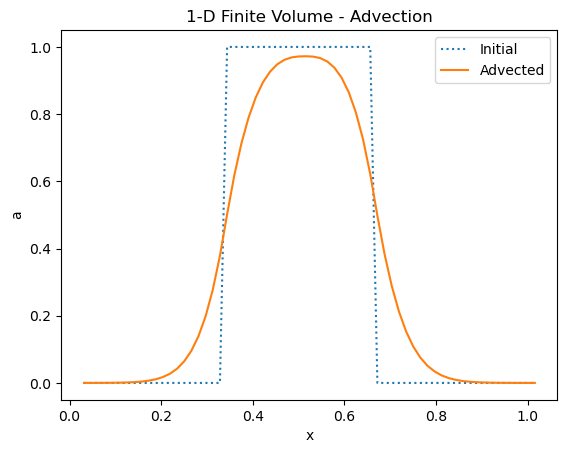

In [4]:
xmin=0
xmax=1
N=64
ngc=2

grid=Grid(N, ngc, xmin=xmin, xmax=xmax)

u=1
C=0.7

sim=Simulate(grid, u, C) #pass through the grid from Grid class

sim.init_cond("tophat") #set up initial conditions

a_init=sim.grid.a.copy() #create copy of original profile to plot

sim.evolution(num_periods=5)

plt.plot(grid.x[grid.low:grid.high+1], a_init[grid.low:grid.high+1],ls=":", label='Initial') #only plot non-ghost cells

plt.plot(grid.x[grid.low:grid.high+1], grid.a[grid.low:grid.high+1],label='Advected')

plt.title('1-D Finite Volume - Advection')
plt.xlabel('x')
plt.ylabel('a')
plt.legend()

In [92]:
sim.flux_list

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.345, 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
        1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 0.655, 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   ]),
 array([0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      

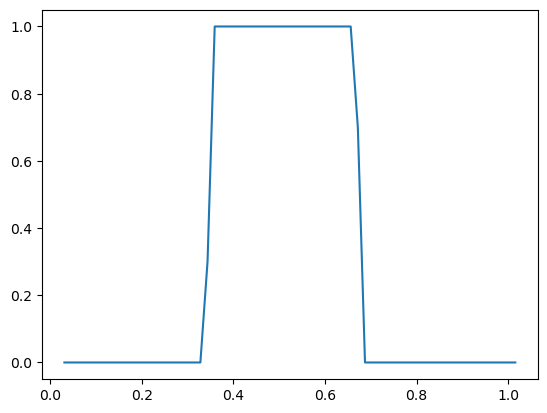

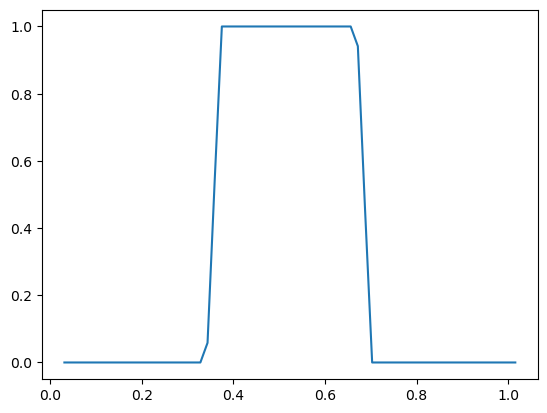

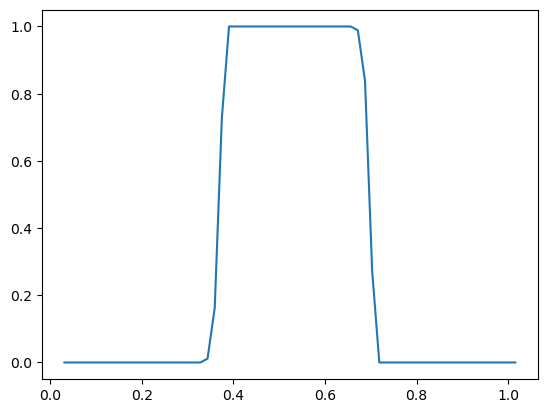

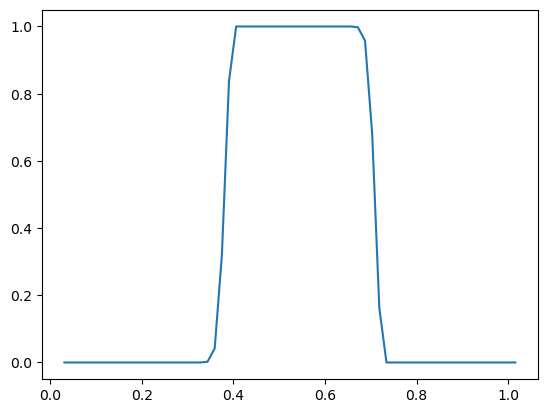

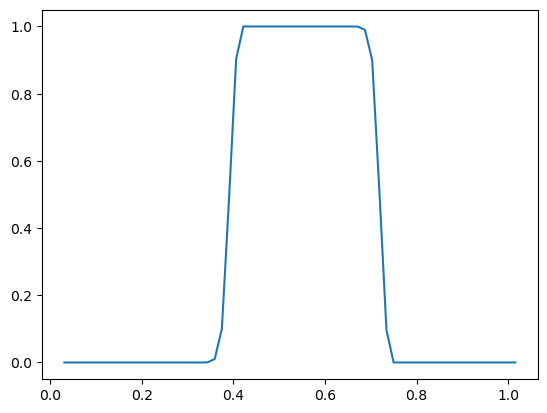

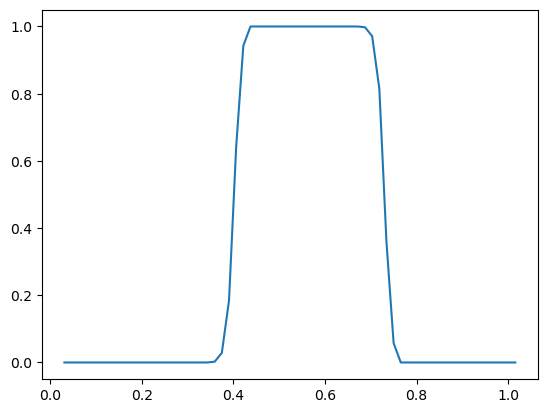

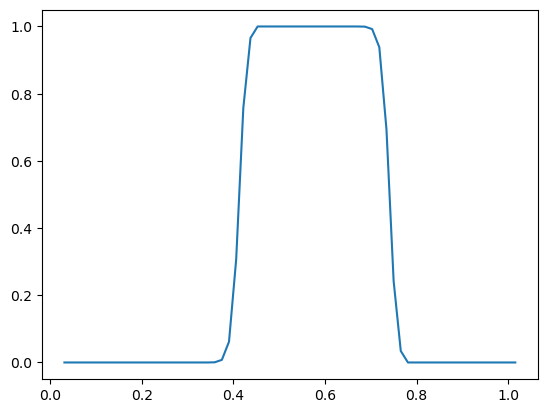

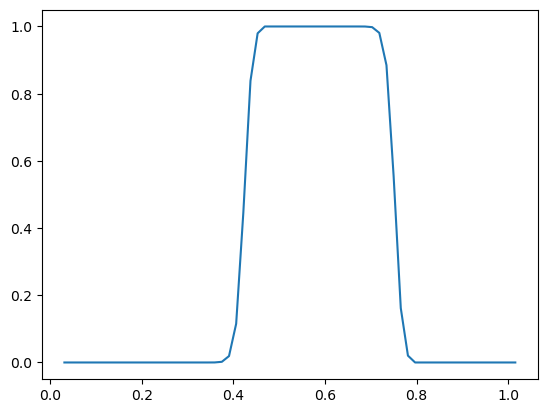

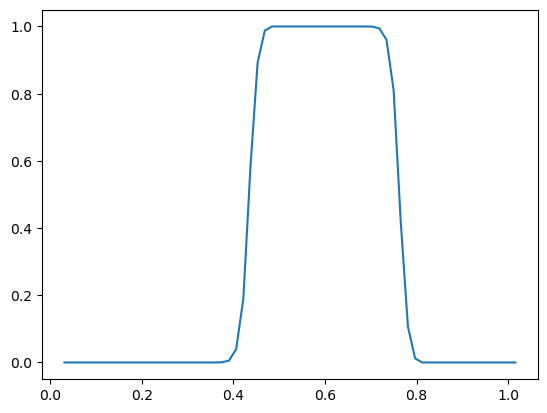

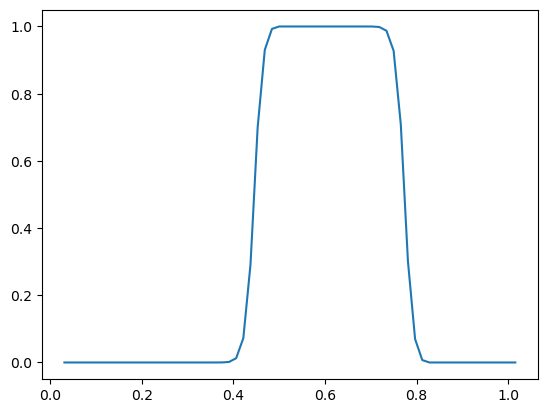

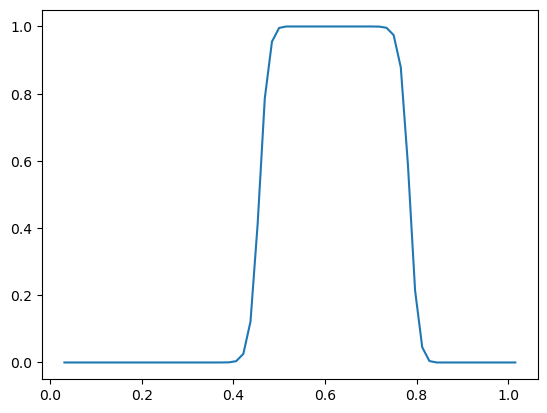

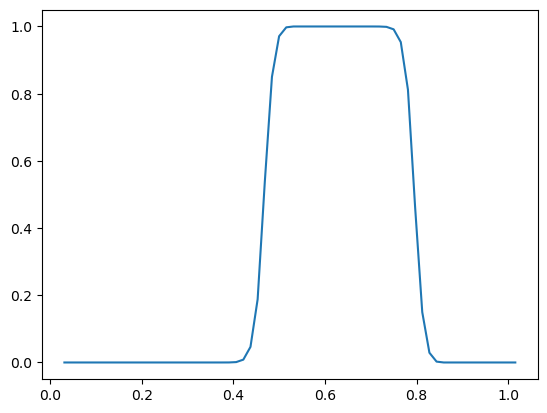

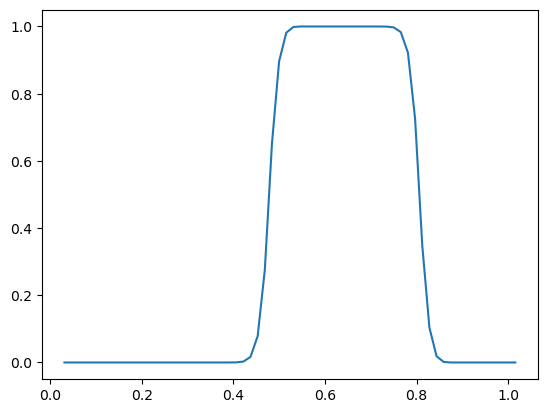

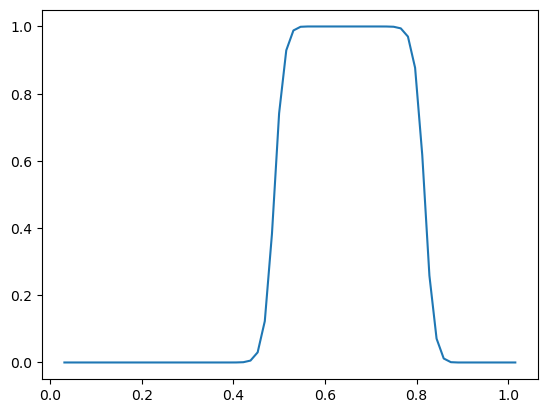

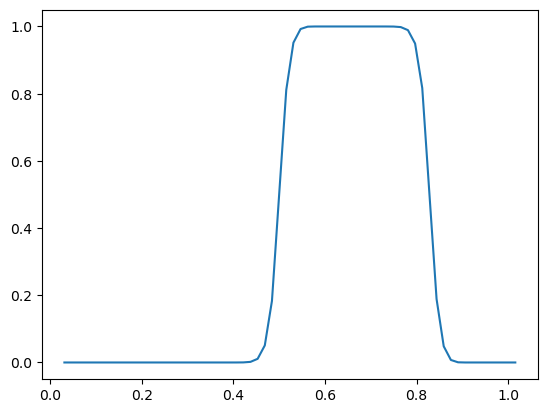

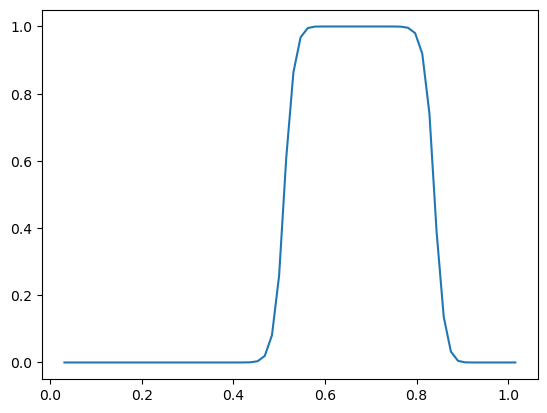

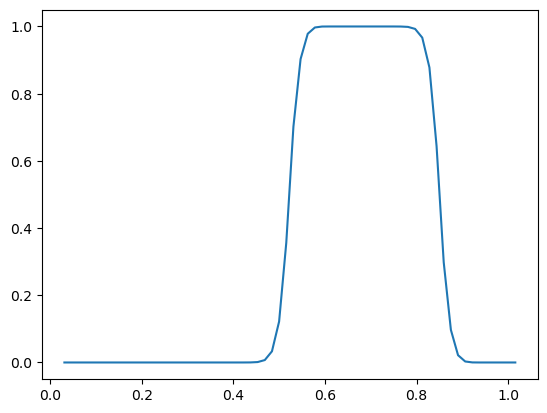

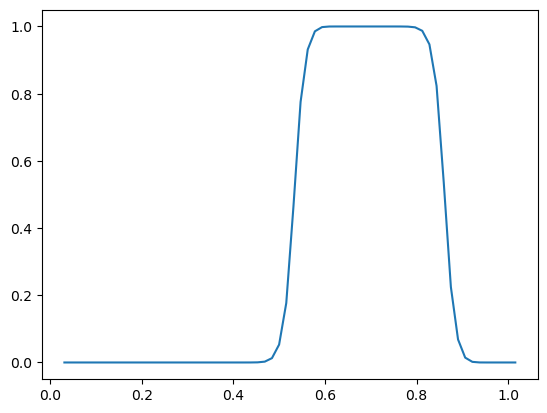

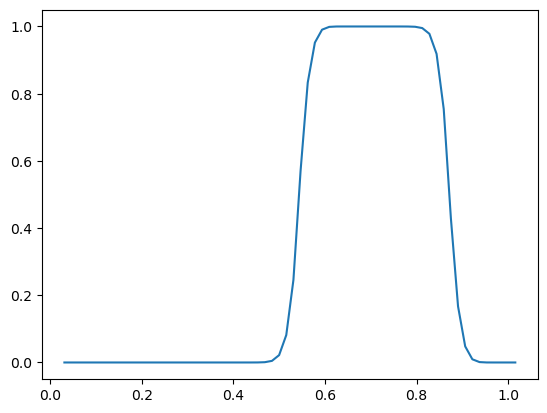

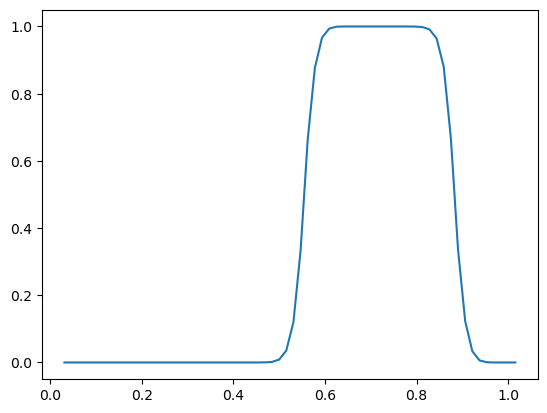

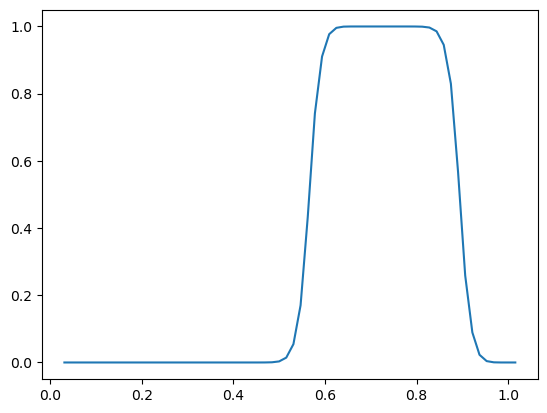

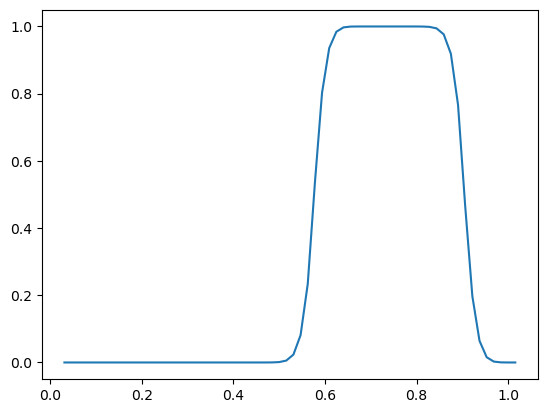

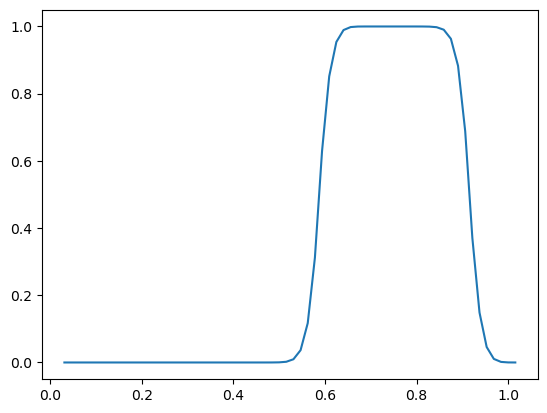

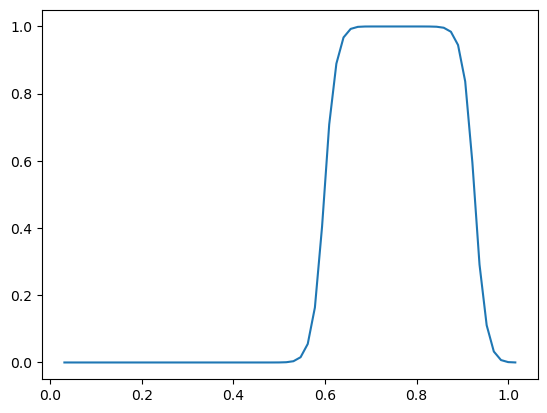

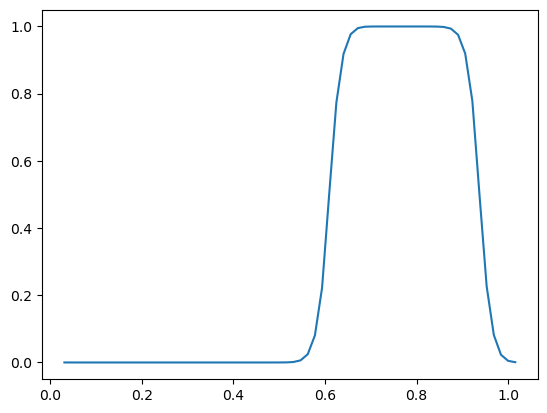

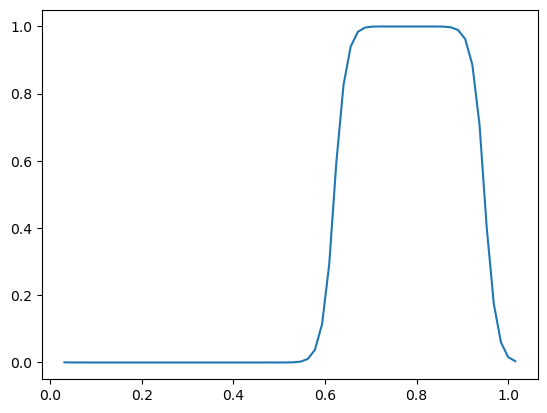

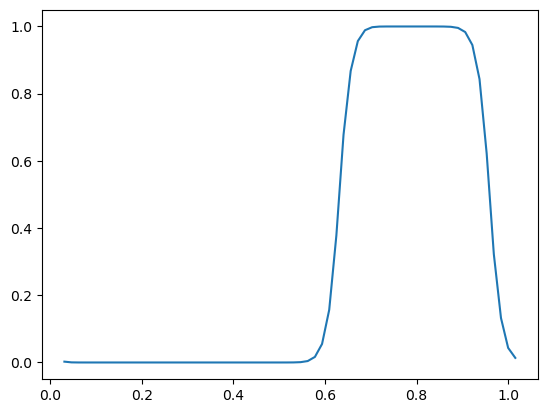

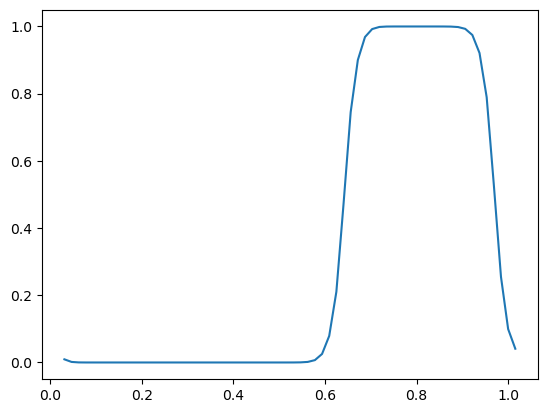

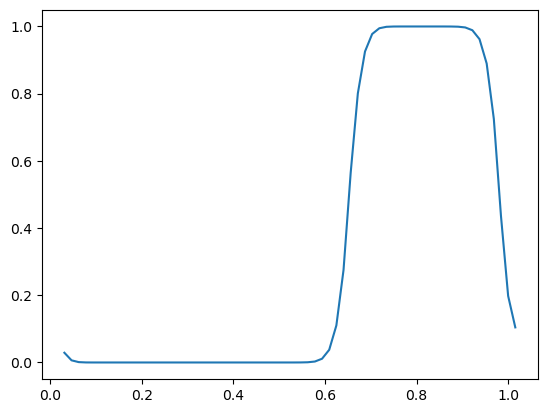

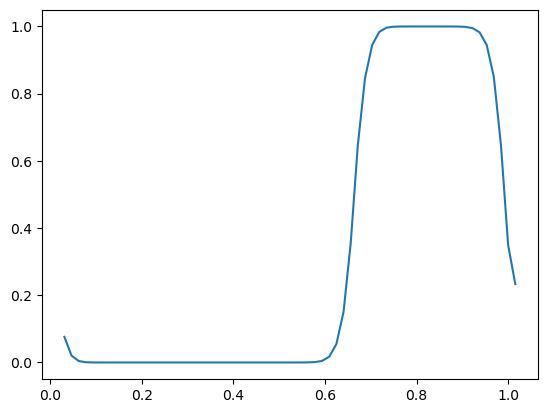

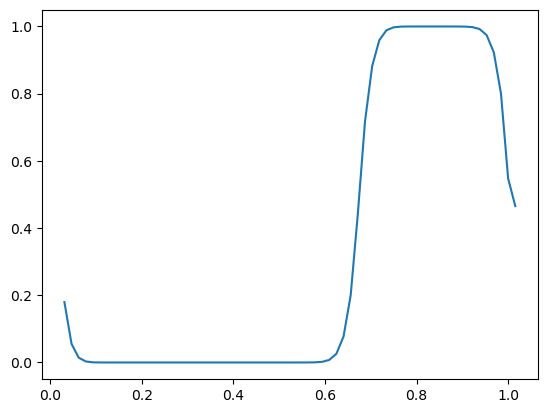

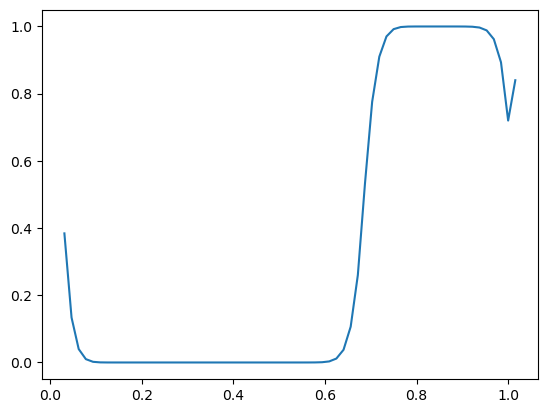

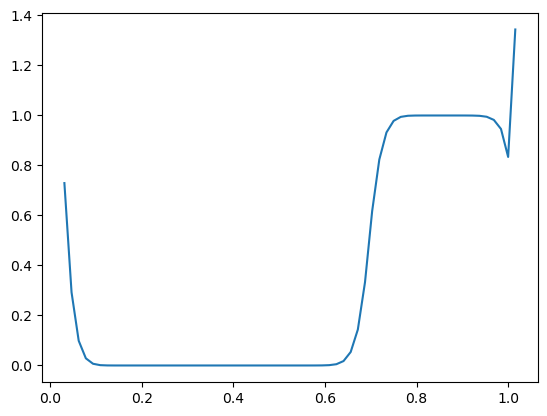

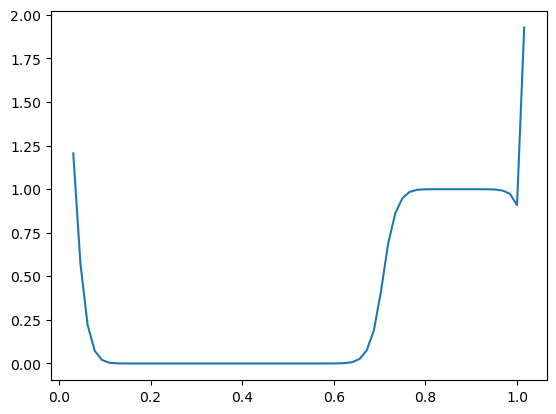

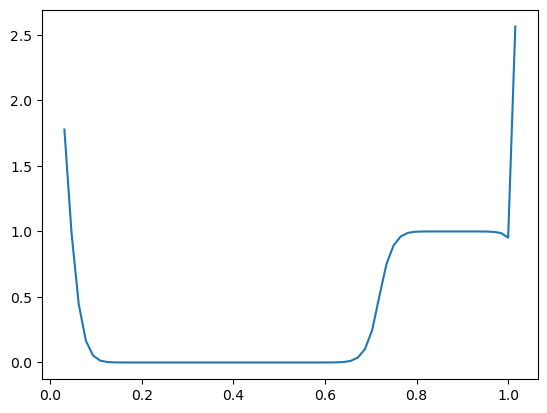

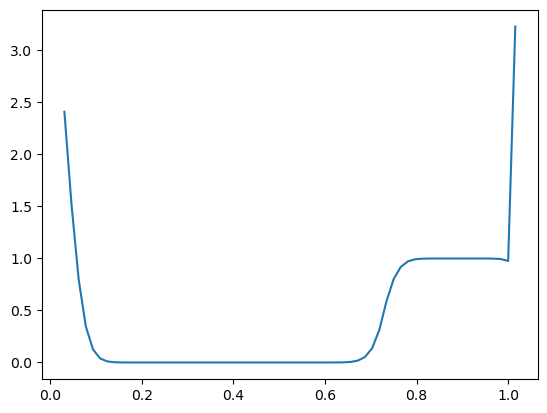

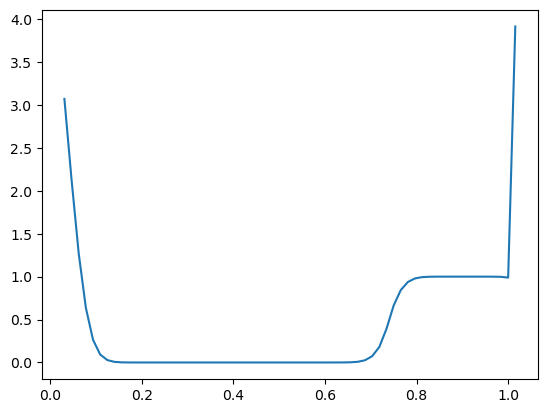

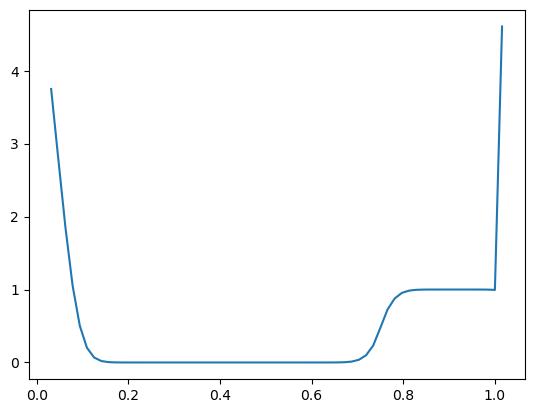

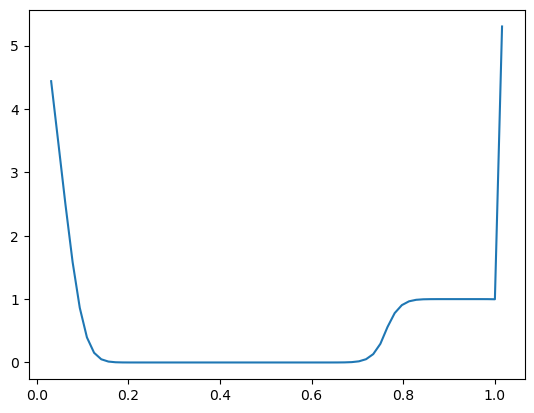

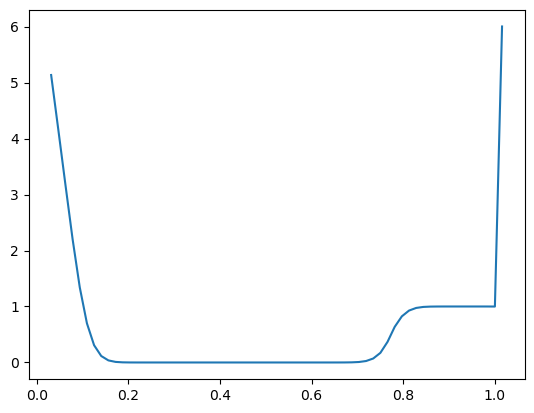

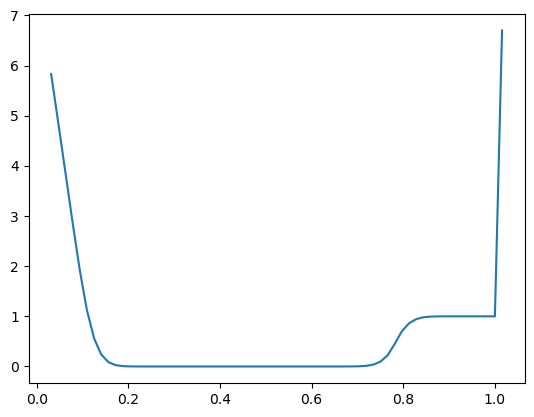

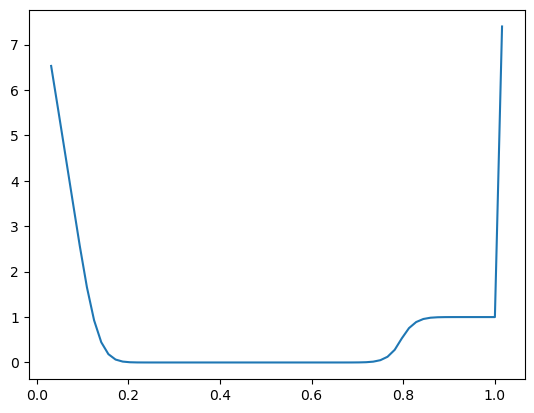

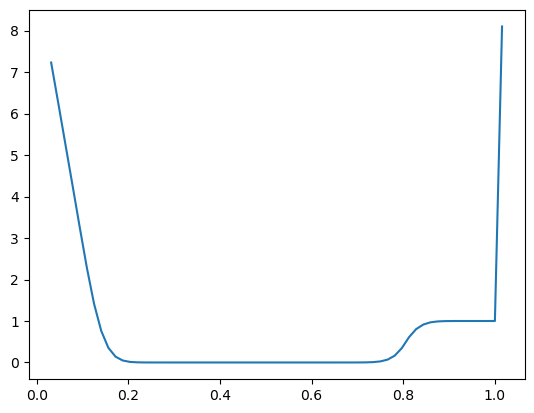

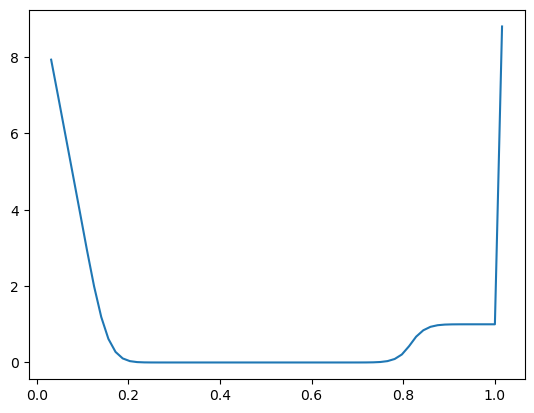

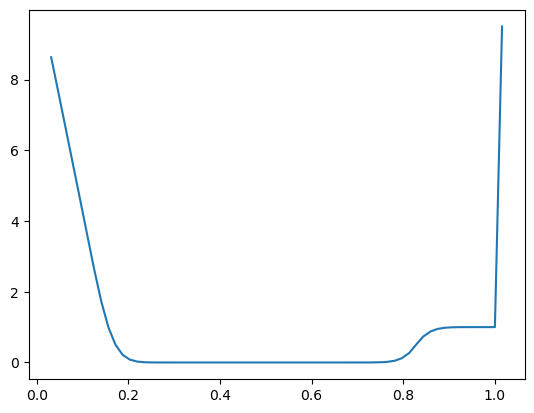

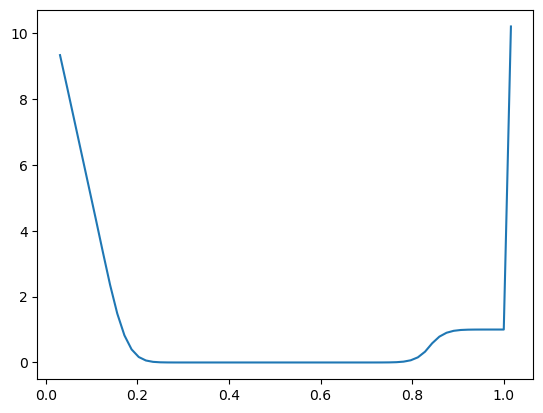

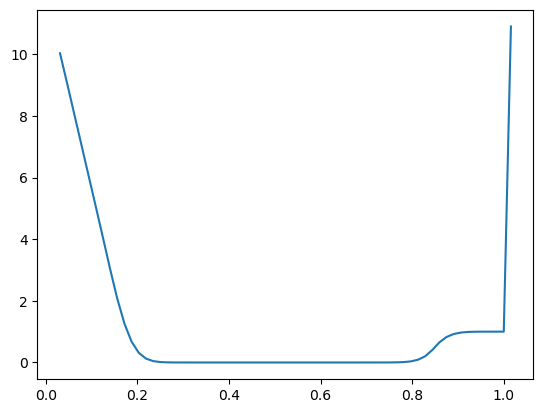

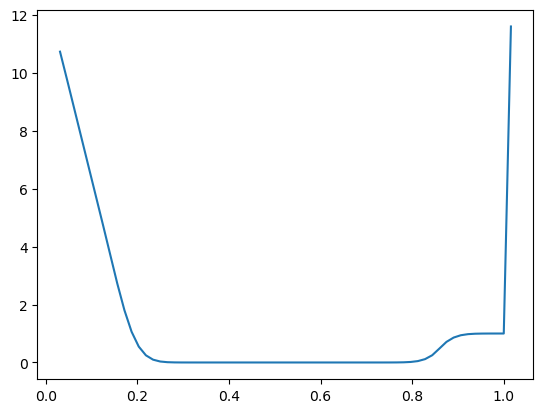

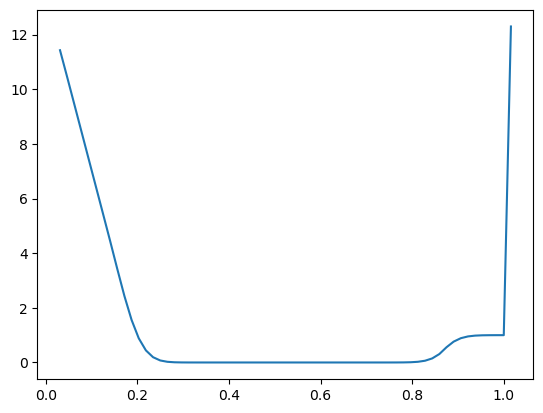

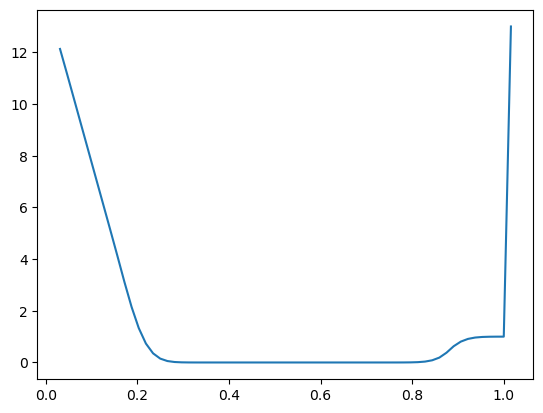

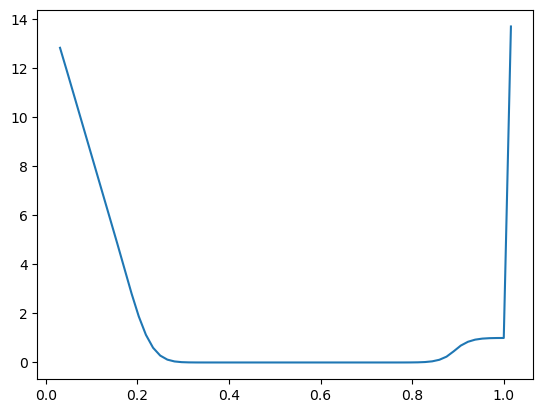

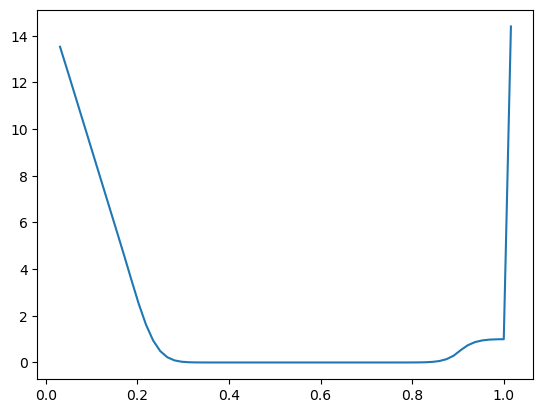

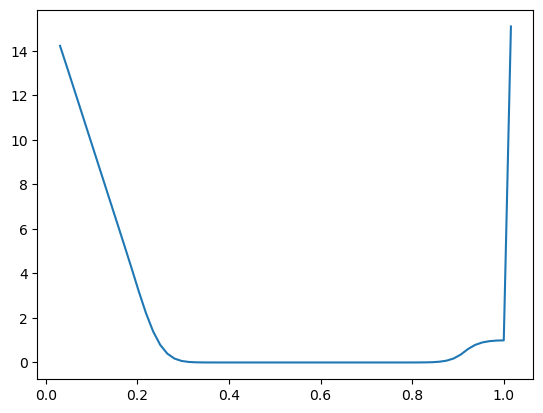

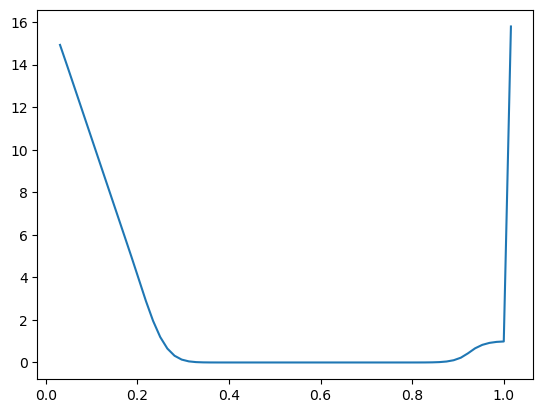

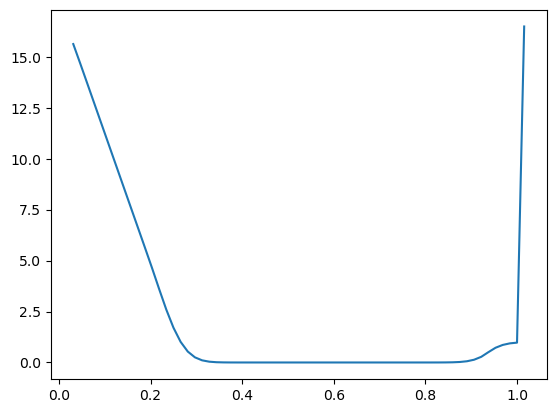

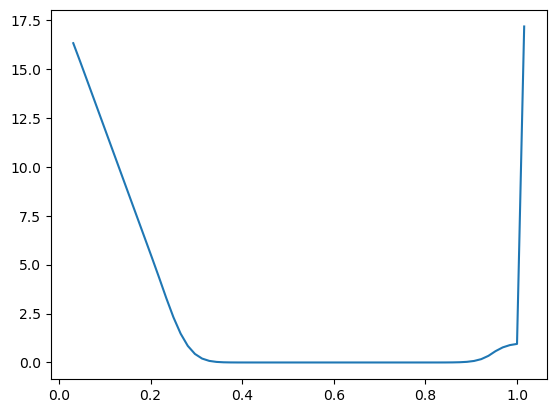

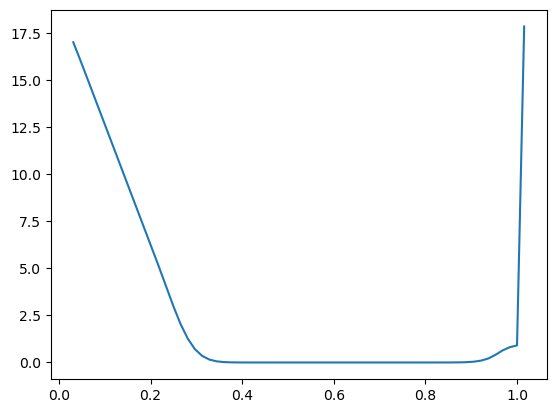

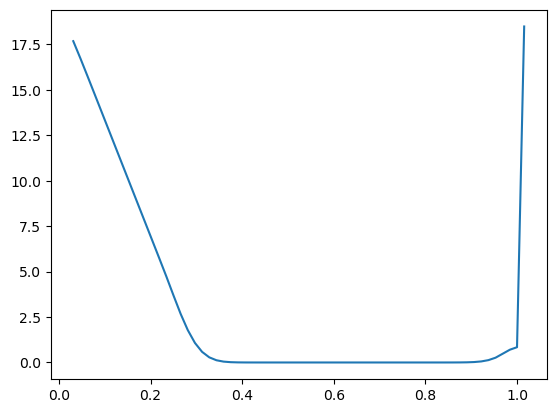

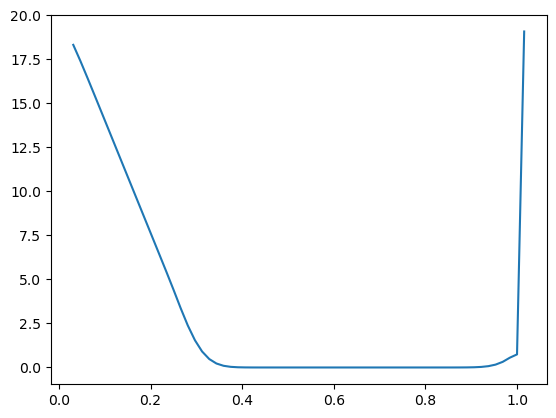

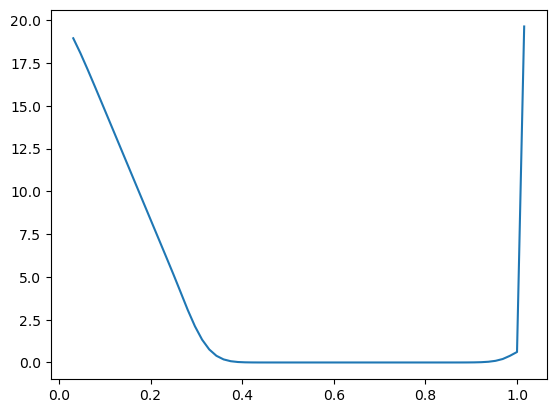

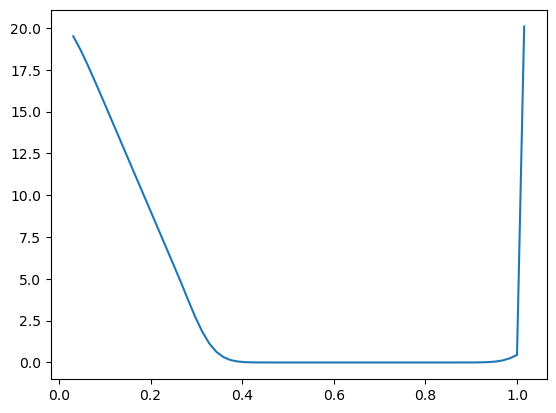

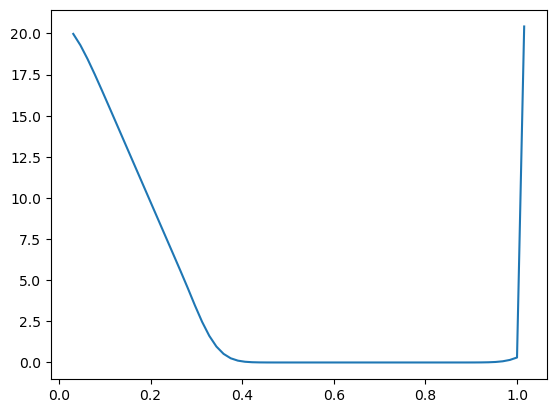

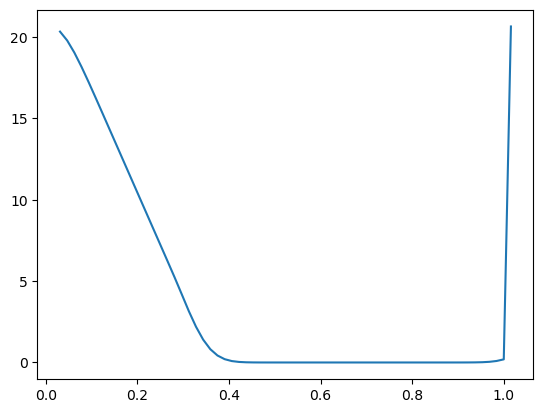

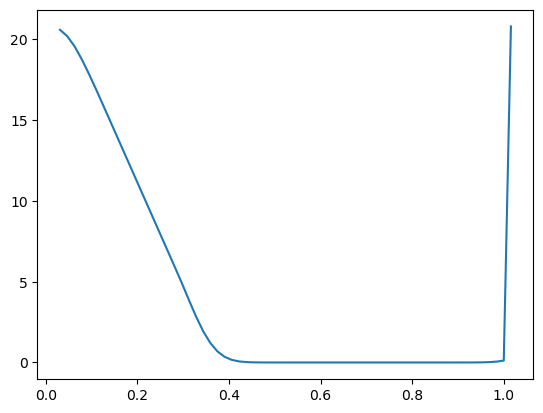

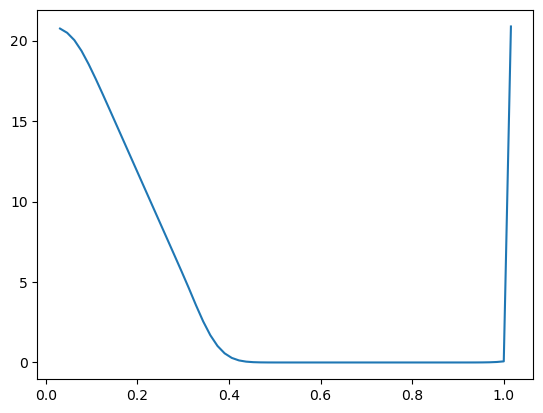

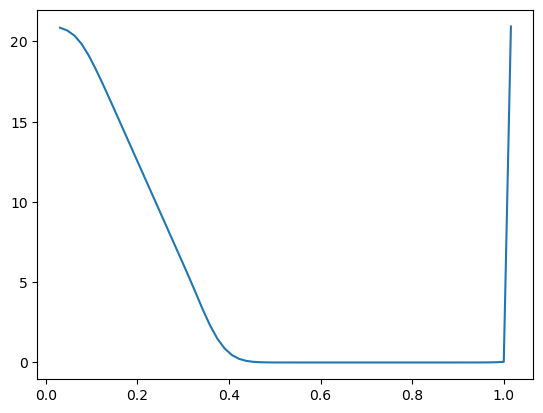

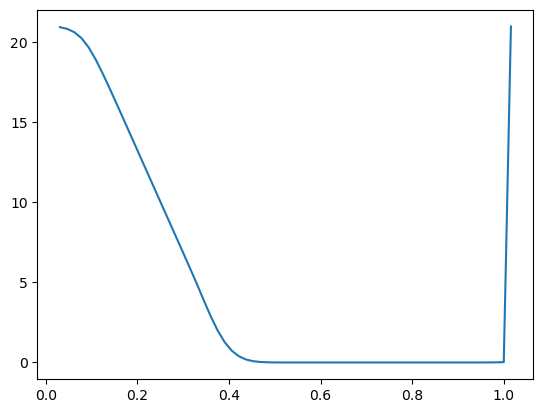

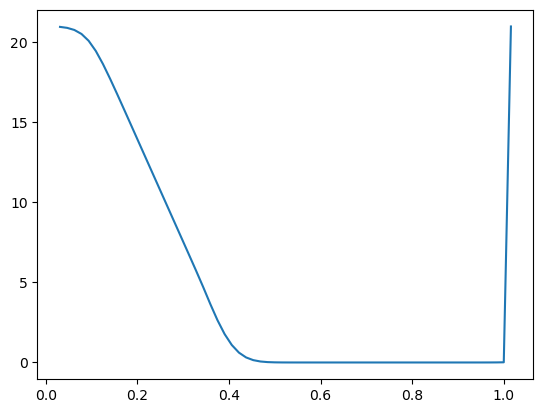

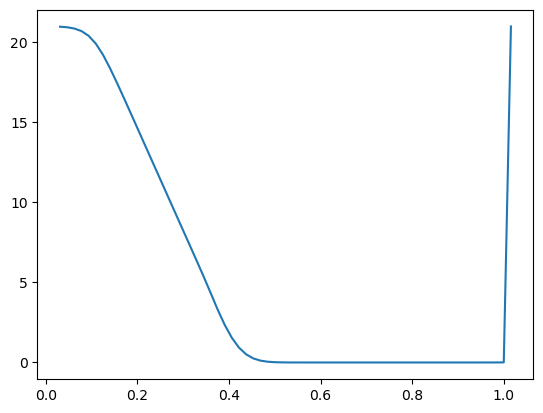

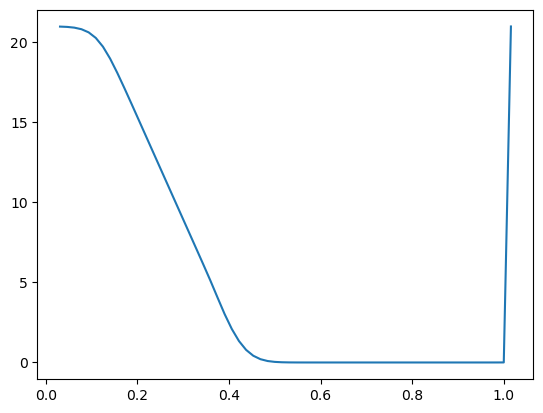

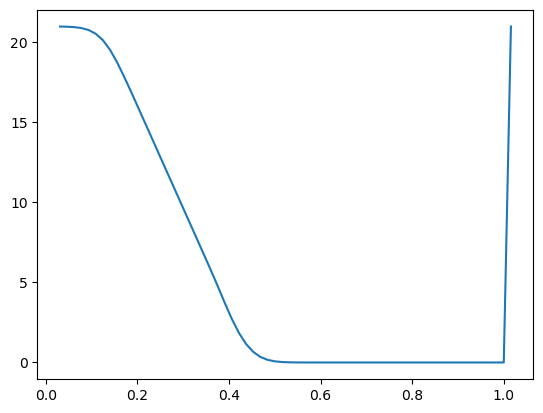

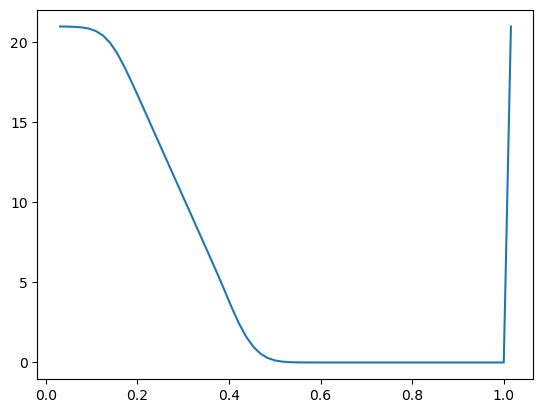

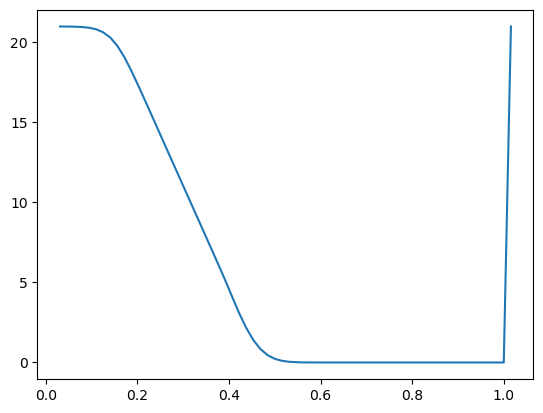

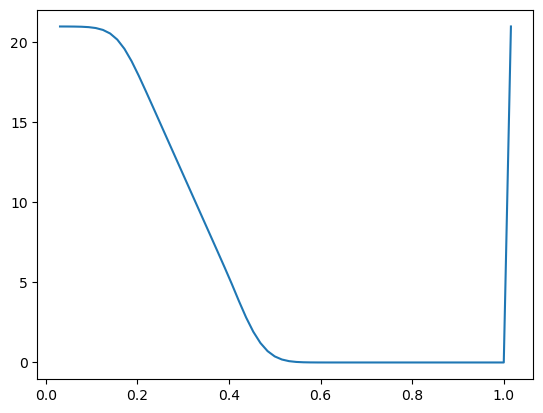

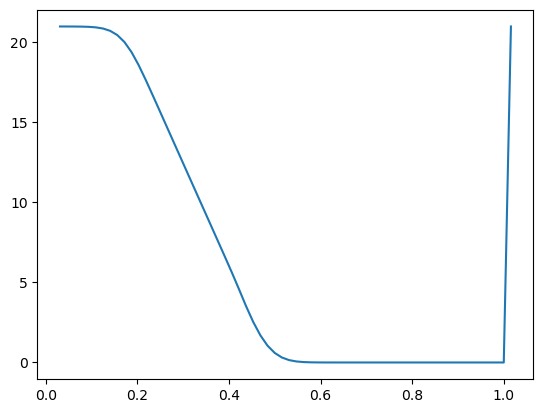

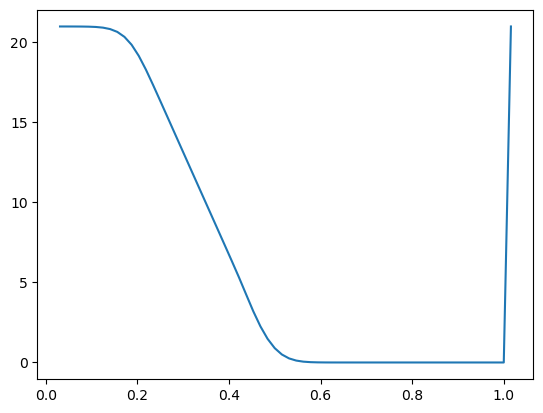

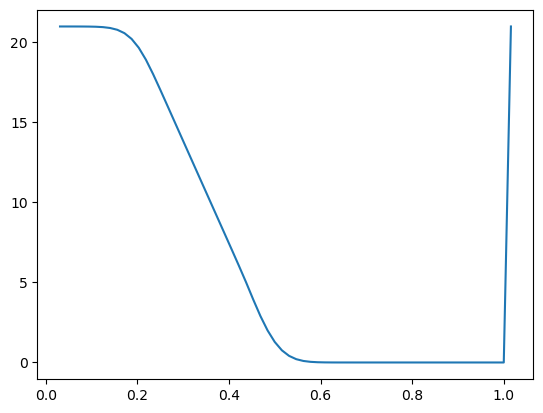

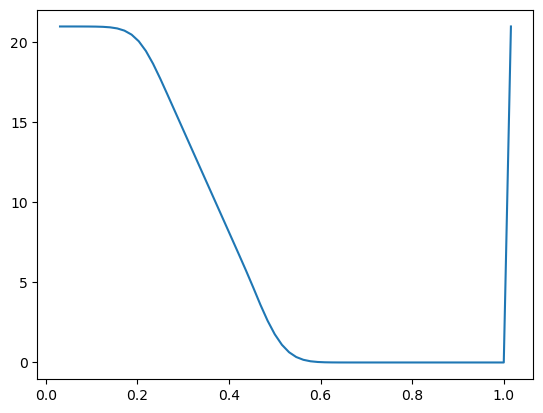

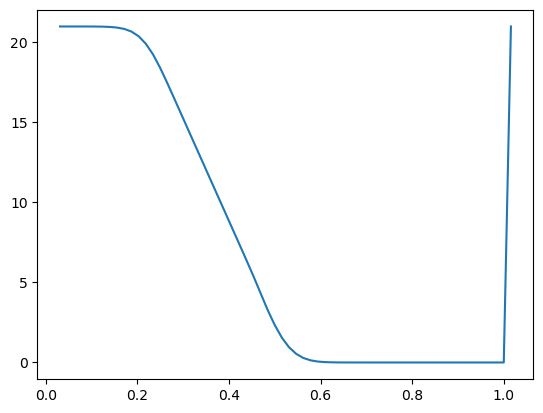

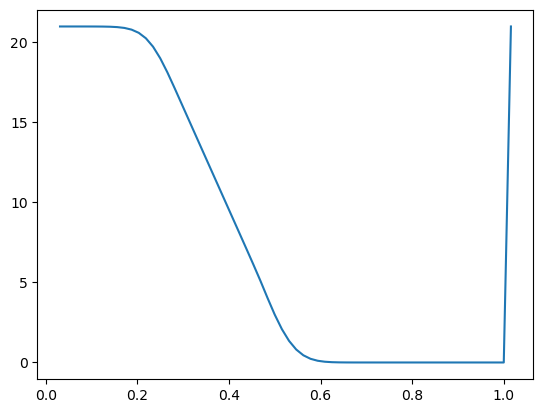

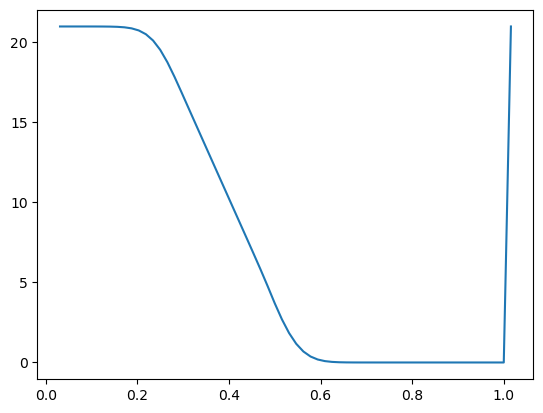

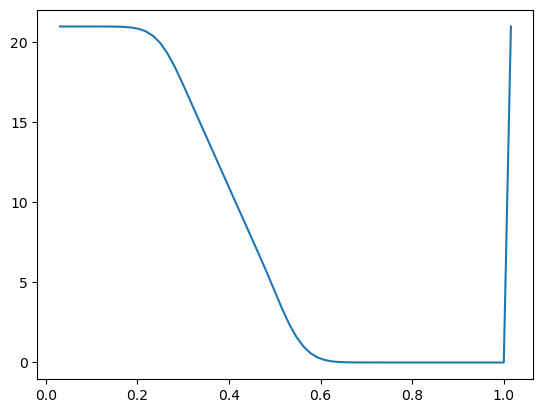

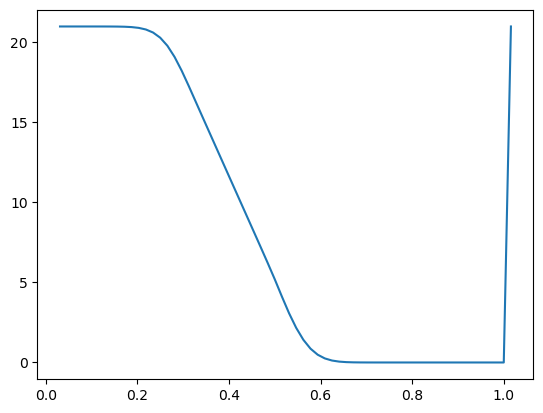

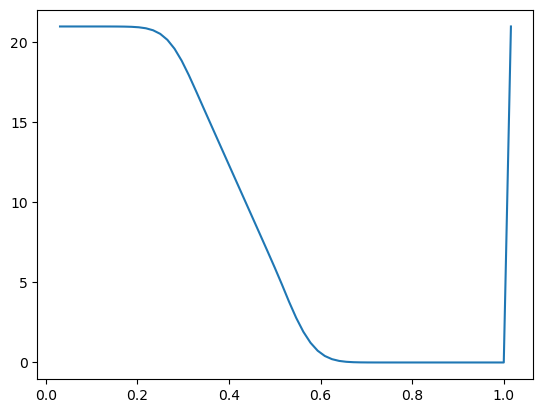

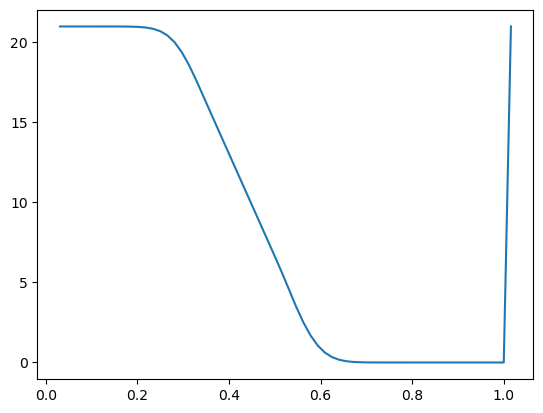

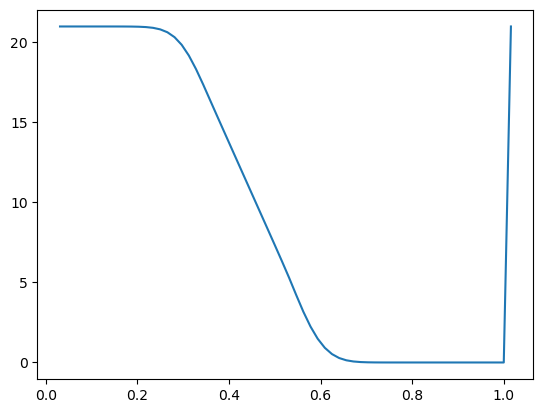

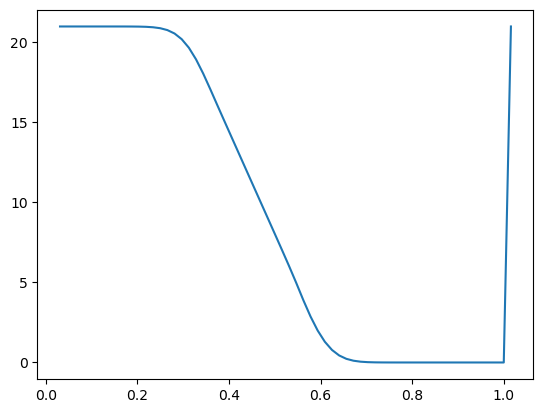

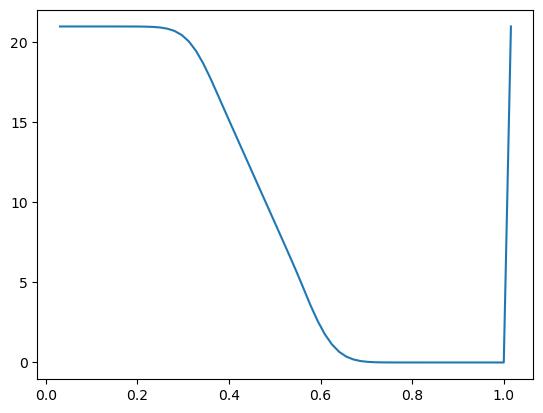

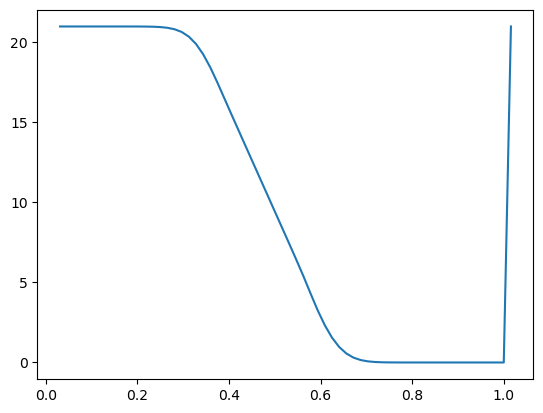

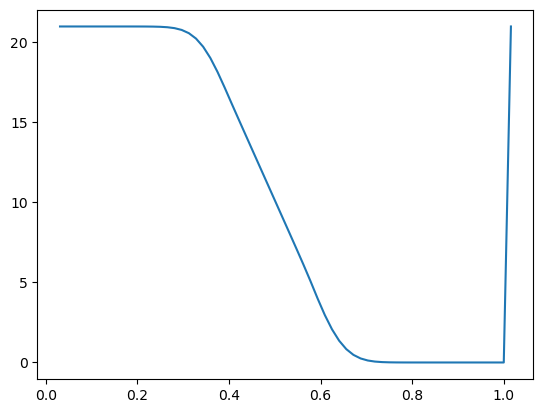

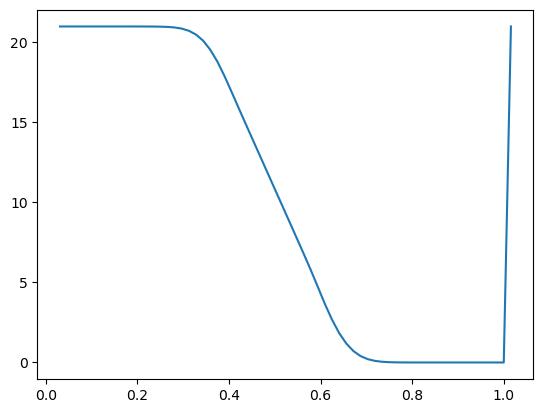

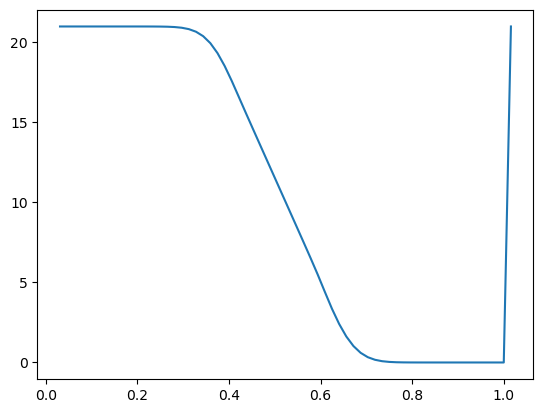

In [175]:
for i in range(len(sim.a_list)):
    plt.plot(grid.x[grid.low:grid.high+1],sim.a_list[i][grid.low:grid.high+1])
    plt.show()